**Updates:**
- 11/22 - Added support for generating synthetic essays of length similar to human essays. Fixed a bug in essay generation.
- 11/23 - Updated prompts to account for maximum length. Still buggy and finding more ways to set this right.

# Motivation

This notebook aims to show how we can generate synthetic essays from `Mistral-7b-instruct-v0.1` model using the prompts given in the `LLM - Detect AI Generated Text` competition.

# Install Libraries

In [1]:
!pip install -q -U git+https://github.com/huggingface/transformers

# Load Model

In [2]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

model_path="/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1"

tokenizer=AutoTokenizer.from_pretrained(model_path)

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype = torch.bfloat16,
    device_map = "auto",
    trust_remote_code = True
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The model is loaded to both the T4 GPUs in ~3minutes. Here is how the memory used.

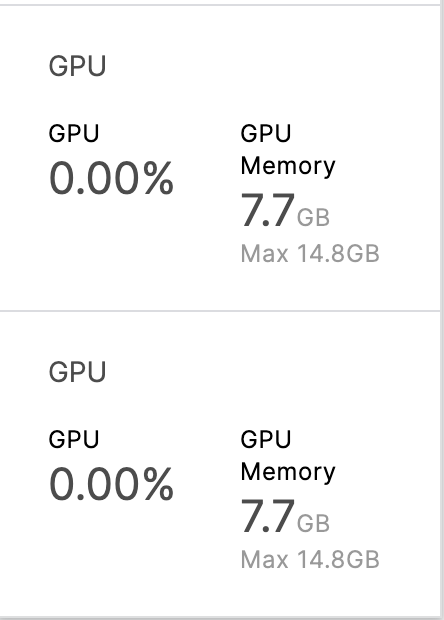

T4 GPUs are a great fit for these tasks compared to P100 due to the lower memory on the latter.

# Generate 1 Essay

Before we generate essays for all the prompts in the dataset, let's create a function that generates 1 essay.

In [3]:
%%time

def generate_essay(prompt):
    messages = [{
        "role":"user",
        "content": prompt
    }]

    model_inputs = tokenizer.apply_chat_template(messages, return_tensors = "pt").to('cuda')
    
    # Setting `pad_token_id` to `eos_token_id` for open-ended generation.
    generated_ids = model.generate(
        model_inputs,
        max_new_tokens = 7500,
        do_sample = True,
        pad_token_id = tokenizer.eos_token_id
        
    )

    decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    text = decoded[0].split("[/INST]")[1]
    return text

prompt = '''You are a student working on the following assignment.

Create an essay based on the following topic in no more than 50 words.

Topic: Car-Free cities.
'''

text = generate_essay(prompt)
text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 15.5 s, sys: 1.77 s, total: 17.3 s
Wall time: 24.9 s


' Car-free cities are becoming increasingly popular as a way to reduce pollution, improve traffic flow, and promote a healthier lifestyle. These cities create a welcoming environment for pedestrians, cyclists, and public transport users, with more green spaces and less noise pollution. However, the idea of eliminating cars entirely may not be feasible for all cities, but implementing partial car-free policies could have numerous benefits.'

# Read Prompts

With the prompts we have in the `train_prompts.csv`, let's generate multiple essays.

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

path = Path("/kaggle/input/llm-detect-ai-generated-text/")

train_prompts = pd.read_csv(f"{path}/train_prompts.csv")

In [5]:
train_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


As we generate synthetic essays, we want to make sure the synthetic essays are closer in length to human essays to ensure the models don't get biased by essay length to distinguish AI generated content from human.

To do this, we generate basic statistics such as average length of essays by humans as well as standard deviation. With these metrics, assuming a normal distribution of lengths for synthetic essays, we randomly sample a number from the normal distribution and generate an essay of that length.

In [6]:
train_essays = pd.read_csv(f"{path}/train_essays.csv")
train_essays['text_length'] = train_essays['text'].str.len()

text_len_mean = int(train_essays.query("generated == 0")['text_length'].mean())
text_len_std = int(train_essays.query("generated == 0")['text_length'].std())

print(f"Mean length of train essays by human in our dataset: {text_len_mean}")
print(f"Mean standard deviation of train essays by human in our dataset: {text_len_std}")

Mean length of train essays by human in our dataset: 3172
Mean standard deviation of train essays by human in our dataset: 918


# Generate Essays

In [7]:
# Defining a configuration object that contains all the parameters at one place.
class CFG:
    guidance_pct = 0.25 # number of times the instructions are shared with the LLM.
    n_essays = 3 # Modify this to generate as many essays you are interested in for each prompt

synthetic_essay_lengths = np.random.normal(text_len_mean, text_len_std, CFG.n_essays * 2).astype(int)
# multiplying by 2 because we want this number for all prompts.

In [8]:
llm_essays = []
essay_counter = 0

for p in train_prompts['prompt_id'].unique():
    for k in tqdm(range(CFG.n_essays), desc=f"prompt_id: {p}"):
        prompt_name = train_prompts.loc[p, 'prompt_name']
        inst = ""
        if np.random.random() < CFG.guidance_pct:
            inst = train_prompts.loc[p, 'instructions']
            prompt_combined = f'''
                You are a student working on the following assignment.

                Create an essay based on the following topic in no more than {synthetic_essay_lengths[essay_counter]} words.

                Topic: ''' \
                + prompt_name \
                + ".\n\n" \
                + "Instructions: \n\n" \
                + inst
        else:
            prompt_combined = f'''
                You are a student working on the following assignment.

                Create an essay based on the following topic in no more than {synthetic_essay_lengths[essay_counter]} words.

                Topic: ''' \
                + prompt_name \
                + ".\n\n" \
        
        # generate the essay
        essay_output = generate_essay(prompt_combined)
        essay_counter += 1
        
        data_output = {
            'prompt_id': p,
            'prompt_name': prompt_name,
            'text': essay_output,
            'generated': 1
        }
        llm_essays.append(data_output)
    
llm_essays = pd.DataFrame(llm_essays)
llm_essays

prompt_id: 1: 100%|██████████| 3/3 [02:59<00:00, 59.82s/it]


,prompt_id,prompt_name,text,generated
0,0,Car-free cities,Car-free cities have been a topic of discussi...,1
1,0,Car-free cities,"In recent years, the trend of cities going ca...",1
2,0,Car-free cities,Car-free cities are becoming increasingly pop...,1
3,1,Does the electoral college work?,"Dear Senator,\n\nI am writing to express my o...",1
4,1,Does the electoral college work?,Is the electoral college an outdated system t...,1
5,1,Does the electoral college work?,"Dear Senator,\n\nI am writing to express my o...",1


Hopefully this notebook showed the process of generating essays using an open-source LLM / local LLM. Just swap out the model name with any model of your choice and you should be able to generate synthetic essays locally without using an API.

Enjoy!